# Homework 1 — Task 3: Logistic Regression Implementation

Refrences:
- Sebastian Ruder (2016), *An overview of gradient descent optimization algorithms*: https://www.ruder.io/optimizing-gradient-descent/
- Stanford CS231n notes, *Optimization*: https://cs231n.github.io/optimization-1/


## 3.1 Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


## 3.2 Load dataset

In [4]:
!wget -q -O bank_marketing.zip https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
!unzip -o bank_marketing.zip -d .
!unzip -o bank.zip

df = pd.read_csv("bank-full.csv", sep=";")
print("Shape:", df.shape)
df.head()


Archive:  bank_marketing.zip
 extracting: ./bank.zip              
 extracting: ./bank-additional.zip   
Archive:  bank.zip
  inflating: bank-full.csv           
  inflating: bank-names.txt          
  inflating: bank.csv                
Shape: (45211, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


## 3.3 Preprocess: one-hot encode, train/test split, scaling


In [6]:
# Encode
y = df["y"].map({"yes": 1, "no": 0}).values.astype(np.float64)

# Features
X_raw = df.drop(columns=["y"])

# One-hot encode
X = pd.get_dummies(X_raw, drop_first=True)
print("Feature matrix shape (after one-hot):", X.shape)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X.values.astype(np.float64),
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train.shape, X_test.shape


Feature matrix shape (after one-hot): (45211, 42)


((36168, 42), (9043, 42))

## 3.4 Vectorized logistic regression: sigmoid, loss, gradients



In [7]:
def sigmoid(z: np.ndarray) -> np.ndarray:
    # Numerically stable sigmoid
    z = np.clip(z, -500, 500)
    return 1.0 / (1.0 + np.exp(-z))

def compute_loss(X: np.ndarray, y: np.ndarray, w: np.ndarray, b: float) -> float:
    """Binary cross-entropy / negative log-likelihood."""
    m = X.shape[0]
    y_hat = sigmoid(X @ w + b)
    eps = 1e-12
    y_hat = np.clip(y_hat, eps, 1 - eps)
    return float(-(1.0 / m) * np.sum(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat)))

def compute_gradients(X: np.ndarray, y: np.ndarray, w: np.ndarray, b: float):
    """Vectorized gradients for w and b."""
    m = X.shape[0]
    y_hat = sigmoid(X @ w + b)
    error = y_hat - y
    dw = (1.0 / m) * (X.T @ error)
    db = float((1.0 / m) * np.sum(error))
    return dw, db

def predict_proba(X: np.ndarray, w: np.ndarray, b: float) -> np.ndarray:
    return sigmoid(X @ w + b)

def predict(X: np.ndarray, w: np.ndarray, b: float, threshold: float = 0.5) -> np.ndarray:
    return (predict_proba(X, w, b) >= threshold).astype(int)

def accuracy(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return float(np.mean(y_true == y_pred))


## 3.5 Gradient Descent variants

three training loops:

1) **Batch Gradient Descent**
- Uses the full dataset gradient each step.
- Typically smooth and stable loss curve.
- Each update is expensive for large datasets.

2) **Stochastic Gradient Descent (SGD)**
- Uses one sample per update (unbiased but high-variance gradient estimate).
- Loss can be noisy; often benefits from smaller/decaying learning rate.
- Cheap updates; can make fast early progress.

3) **Mini-batch Gradient Descent**
- Uses a small batch (32/64/128).
- Lower variance than SGD, cheaper than batch GD.
- Common practical default because it’s both stable and fast with vectorization.

(Ruder (2016) and CS231n optimization)


In [8]:
def fit_batch_gd(X, y, lr=0.1, epochs=200):
    m, d = X.shape
    w = np.zeros(d)
    b = 0.0
    loss_hist = []

    for epoch in range(epochs):
        dw, db = compute_gradients(X, y, w, b)
        w -= lr * dw
        b -= lr * db
        loss_hist.append(compute_loss(X, y, w, b))

    return w, b, loss_hist

def fit_sgd(X, y, lr=0.05, epochs=25, shuffle=True, seed=42):
    m, d = X.shape
    w = np.zeros(d)
    b = 0.0
    loss_hist = []

    rng = np.random.default_rng(seed)

    for epoch in range(epochs):
        idx = np.arange(m)
        if shuffle:
            rng.shuffle(idx)

        for i in idx:
            Xi = X[i:i+1]  # (1, d)
            yi = y[i:i+1]  # (1,)
            dw, db = compute_gradients(Xi, yi, w, b)
            w -= lr * dw
            b -= lr * db

        # Track full-data loss per epoch (for comparability)
        loss_hist.append(compute_loss(X, y, w, b))

    return w, b, loss_hist

def fit_minibatch_gd(X, y, lr=0.05, epochs=100, batch_size=64, shuffle=True, seed=42):
    m, d = X.shape
    w = np.zeros(d)
    b = 0.0
    loss_hist = []

    rng = np.random.default_rng(seed)

    for epoch in range(epochs):
        idx = np.arange(m)
        if shuffle:
            rng.shuffle(idx)

        for start in range(0, m, batch_size):
            batch_idx = idx[start:start + batch_size]
            Xb = X[batch_idx]
            yb = y[batch_idx]
            dw, db = compute_gradients(Xb, yb, w, b)
            w -= lr * dw
            b -= lr * db

        loss_hist.append(compute_loss(X, y, w, b))

    return w, b, loss_hist


## 3.6 Train + compare Batch GD vs SGD vs Mini-batch GD

Compare:
- Training loss per epoch
- Test accuracy


In [9]:
# Train (feel free to tune learning rates / epochs)
w_batch, b_batch, loss_batch = fit_batch_gd(X_train, y_train, lr=0.1, epochs=200)
w_sgd, b_sgd, loss_sgd = fit_sgd(X_train, y_train, lr=0.05, epochs=25)
w_mb, b_mb, loss_mb = fit_minibatch_gd(X_train, y_train, lr=0.05, epochs=100, batch_size=64)

# Evaluate on test set
pred_batch = predict(X_test, w_batch, b_batch)
pred_sgd = predict(X_test, w_sgd, b_sgd)
pred_mb = predict(X_test, w_mb, b_mb)

acc_batch = accuracy(y_test, pred_batch)
acc_sgd = accuracy(y_test, pred_sgd)
acc_mb = accuracy(y_test, pred_mb)

(acc_batch, acc_sgd, acc_mb)


(0.9001437576025655, 0.886431493973239, 0.9009178370009953)

### Loss curves

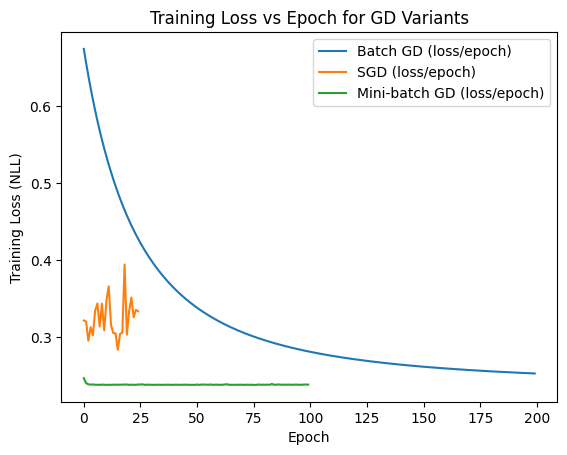

In [10]:
plt.figure()
plt.plot(loss_batch, label="Batch GD (loss/epoch)")
plt.plot(loss_sgd, label="SGD (loss/epoch)")
plt.plot(loss_mb, label="Mini-batch GD (loss/epoch)")
plt.xlabel("Epoch")
plt.ylabel("Training Loss (NLL)")
plt.title("Training Loss vs Epoch for GD Variants")
plt.legend()
plt.show()


### Accuracy summary table

In [11]:
pd.DataFrame({
    "Method": ["Batch GD", "SGD", "Mini-batch GD"],
    "Test Accuracy": [acc_batch, acc_sgd, acc_mb],
    "Epochs Trained": [len(loss_batch), len(loss_sgd), len(loss_mb)]
})


,Method,Test Accuracy,Epochs Trained
0,Batch GD,0.900144,200
1,SGD,0.886431,25
2,Mini-batch GD,0.900918,100


## 3.7 Convergence properties

**Batch Gradient Descent**
- Uses the full dataset gradient each update → low-variance updates.
- For convex logistic regression, with a suitable learning rate, the loss tends to decrease smoothly and converge reliably.
- Per-update cost is high because each step uses all training examples.

**Stochastic Gradient Descent (SGD)**
- Uses one example per update → unbiased gradient estimate but high variance.
- Loss trajectory is noisier and may “bounce” near the optimum; convergence is often described in expectation and improved with learning-rate decay.
- Very fast updates; often makes quick early progress.

**Mini-batch Gradient Descent**
- Uses a small batch per update → reduces SGD variance while retaining speed and vectorization.
- Typically converges faster in wall-clock time than batch GD and is more stable than pure SGD.
- Batch size is a hyperparameter that trades off noise vs compute.

